## IS 2nd seminar ## 
For the second assignment in the Intelligent Systems course, our task was to create a program for the recognition of fake news articles.
We will tackle this problem using machine learning (ML) algorithms. These are algorithms that can improve automatically through experience and by the use of data. They build a model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so. They are used in a wide variety of applications, such as in medicine, email filtering, speech recognition, and computer vision, where it is difficult or unfeasible to develop conventional algorithms to perform the needed tasks. 
This property makes ML the perfect tool for our work on the second assignment, as it would be impossible to hard-code a solution that would accurately detect all(or even most) fake news articles.

In [1]:
import pandas as pd
import numpy as np
import operator
import emoji
import unidecode
import matplotlib.pyplot as plt
%matplotlib inline
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
import time

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ziga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

First we split the data into two separate sets, a training set and a test set. We must take care not to mix the two as that would invalidate the learning of our machine learning algorithms.

In [3]:
test = pd.read_csv("C:\\Users\\Ziga\\Desktop\\IS-seminar\\#2\\test_data.tsv",sep="\t", header=0)
train = pd.read_csv("C:\\Users\\Ziga\\Desktop\\IS-seminar\\#2\\train_data.tsv",sep="\t", header=0)

**Check if data was read**

In [4]:
#train.head(1)

In [5]:
#test.head(1)

**True vs Fake news ratio**

In [7]:
#train['label'].value_counts()

## Small data analysis ##

To build a model we must first find out which attributes define the solution well. We check to see how well attributes like text length, presence of special characters, number of words used, specific word occurences and even emoji presence polarize the fake and real news.

**Length of news**

In [8]:
length_true_news = train[train['label']==1]['text_a'].str.len()
length_fake_news = train[train['label']==0]['text_a'].str.len()

In [9]:
# average length of real news
print('Average length of real news '+str(length_true_news.mean()))

# average length of fake news 
print('Average length of fake news '+str(length_fake_news.mean()))

Average length of real news 246.57851985559566
Average length of fake news 171.77135260884015


**Characters in sentence (checks for links too)**

In [10]:
characters = ['!','?','@','#','&',';','$',':','http']
train['symbols'] = train['text_a'].apply(lambda x: 1 if any(cht in x for cht in characters) else 0)

**Splitting only on character presence**

In [11]:
train['symbols'].value_counts()

1    4340
0    1993
Name: symbols, dtype: int64

In [12]:
train['l&s'] = ((train['label']==False) & (train['symbols']==True)).astype(int)

**If label = 0 and symbol is present l&s = 1**

In [13]:
train.head(5)

,label,text_a,symbols,l&s
0,1,#Coronavirus: Prime Minister Boris Johnson...,1,0
1,0,Global coronavirus deaths exceed 800000 h...,1,1
2,1,The US has the highest number of #COVID...,1,0
3,1,Many more cities and states will start ...,1,0
4,1,#IndiaFightsCorona: Japan commits Rs 3500 ...,1,0


In [14]:
train['l&s'].value_counts()

0    4887
1    1446
Name: l&s, dtype: int64

**Splitting on word count**

In [15]:
train['word_num'] = train['text_a'].apply(lambda x: len(x.split()))

In [16]:
train.head(10)

,label,text_a,symbols,l&s,word_num
0,1,#Coronavirus: Prime Minister Boris Johnson...,1,0,22
1,0,Global coronavirus deaths exceed 800000 h...,1,1,6
2,1,The US has the highest number of #COVID...,1,0,27
3,1,Many more cities and states will start ...,1,0,24
4,1,#IndiaFightsCorona: Japan commits Rs 3500 ...,1,0,30
5,0,doctors and nurses in medical uniforms l...,0,0,15
6,0,COVID-19: Man Insisting That He Will 'Di...,1,1,13
7,1,There are 37 people isolating in the Au...,0,0,27
8,1,Florida also had a major problem with a...,1,0,21
9,0,Indian business tycoon Ratan Tata said t...,0,0,14


In [17]:
train['word_num'].mean()

27.4778146218222

In [18]:
print('Average word count in fake news '+str(train[train['label']==0]['word_num'].mean()))
print('Average word count in real news '+str(train[train['label']==1]['word_num'].mean()))

Average word count in fake news 22.708873379860417
Average word count in real news 31.79482551143201


**Word occurrence**

In [19]:
def word_count(text):
    count = dict()
    for sentence in text:
        words = sentence.split()
        
        for word in words:
            if word in count:
                count[word] += 1
            else:
                count[word] =1
    return count

In [20]:
text_fake = train[train['label']==0]['text_a']
text_true = train[train['label']==1]['text_a']

#fake_dict = word_count(text_fake)
#true_dict = word_count(text_true)

In [21]:
#dict( sorted(word_count(text_fake).items(), key=operator.itemgetter(1),reverse=True))

In [22]:
#dict( sorted(word_count(text_true).items(), key=operator.itemgetter(1),reverse=True))

**Emoji presence**

In [23]:
def check(sentence):
    for ch in sentence:
        if emoji.get_emoji_regexp().search(ch):
            return 1
    return 0

In [24]:
train['emoji'] = train['text_a'].apply(lambda x: check(x))

In [25]:
train.head(11)

,label,text_a,symbols,l&s,word_num,emoji
0,1,#Coronavirus: Prime Minister Boris Johnson...,1,0,22,0
1,0,Global coronavirus deaths exceed 800000 h...,1,1,6,0
2,1,The US has the highest number of #COVID...,1,0,27,0
3,1,Many more cities and states will start ...,1,0,24,0
4,1,#IndiaFightsCorona: Japan commits Rs 3500 ...,1,0,30,0
5,0,doctors and nurses in medical uniforms l...,0,0,15,0
6,0,COVID-19: Man Insisting That He Will 'Di...,1,1,13,0
7,1,There are 37 people isolating in the Au...,0,0,27,0
8,1,Florida also had a major problem with a...,1,0,21,0
9,0,Indian business tycoon Ratan Tata said t...,0,0,14,0


In [26]:
len(train[(train['emoji']==1) & (train['label']==0)])

41

Now that we have familiarized ourselves with the data somewhat we can start working on an algorithm. Defined below is a general overview off our workflow.
- **Work Flow**

    - Data pre processing
    - Train Test split, already done
    - Logistic Regression model (always good for binary classification)
    - Naive Bayes
    - Feed test data to our model and analyze accuracy

## PRE-PROCESSING ##

Before any training is done, we must process our data. This is due to the data being noisy and some information may even be missing. We first check all the articles for missing values, as we have little to gain from them and would have to handle them by either filling them in or removing them. Luckily our data has no missing values. We decided we prefer having the label for fake news to be 1, so the next step was to flip the labels in the given data. After that we just split the labels into a separate vector so as to truly work only with unlabeled data.
- **Switched label 0->1, 1->0**
    - **1: Fake news, 0: Real news**

In [27]:
train_reversed_label = train.copy(deep=True)
test_reversed_label = test.copy(deep=True)

In [28]:
train_reversed_label['label']=train_reversed_label['label'].apply(lambda x: 0 if(x==1) else 1).values
test_reversed_label['label']=test_reversed_label['label'].apply(lambda x: 0 if(x==1) else 1).values

In [29]:
#train_reversed_label = train_reversed_label.drop(columns=['symbols','l&s','word_num', 'emoji'], axis = 1)

In [30]:
#train_reversed_label

In [31]:
#test_reversed_label

In [32]:
#print(stopwords.words('english'))

**Check for missing data**

In [33]:
train_reversed_label.isnull().sum()

label       0
text_a      0
symbols     0
l&s         0
word_num    0
emoji       0
dtype: int64

**Separating the data: label and text in different arrays**

In [34]:
X = train_reversed_label.drop('label', axis=1)
Y = train_reversed_label['label']
X_test = test_reversed_label.drop('label', axis=1)
Y_test = test_reversed_label['label']

In [35]:
#text_processing_X = train_reversed_label.drop('label', axis=1)
#text_processing_Y = train_reversed_label['label']

#text_processing_X_test = test_reversed_label.drop('label', axis=1)
#text_processing_Y_test = test_reversed_label['label']

#text_processing_X = text_processing_X.append(text_processing_X_test)
#text_processing_Y = text_processing_Y.append(text_processing_Y_test)

In [36]:
#print(X)
#print(Y)
#print(X_test)
#print(Y_test)

#print(text_processing_Y)

At this point we are ready to process our actual unlabeled data. Since it is in text form rather than numeric, which is the only form ML alogithms can understand, we will have to convert it but not before stemming the data first.
Stemming, is the process of reducing a word to its root. For example the words actor, actress and acting are all reduced to act. This greatly increases the efficiency of our algorithm as it reduces redundancy due to different words carrying the same general context. In this step we also remove links and stopwords from the text as they carry little to no significance. 
- **Preparing/cleaning the data**
    - stemming (swimming, swimmer -> swim) reduce the word to the root word
    - convert text to numerical data
    - convert all letters to lower ones
    - remove links, emojis

In [37]:
port_stem = PorterStemmer()

In [38]:
def stemming(content):
    stemmed_content = re.sub(r'http\S+',' ', content)
    stemmed_content = re.sub('[^a-zA-Z]',' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [39]:
X = X['text_a'].apply(stemming)

In [40]:
X_test = X_test['text_a'].apply(stemming)

**Convert text to numerical values**
Next we convert the text data to numeric values using the TfidfVectorizer class. This turns our collection of text documents into numerical feature vectors. Tf-idf is short for term frequency times inverse document frequency meaning the vectorization of words takes into account how often the words appear in separate documents as well as overall occurences. Calling the transform function returns a Tf-idf-weighted document-term matrix.

**We put the training and test data together**

In [41]:
X = X.append(X_test)
Y = Y.append(Y_test)

text_processing_X = X.copy(deep=True)
text_processing_Y = Y.copy(deep=True)

In [42]:
a=dict( sorted(word_count(X).items(), key=operator.itemgetter(1),reverse=True))
b = {k: a[k] for k in list(a)[:20]}

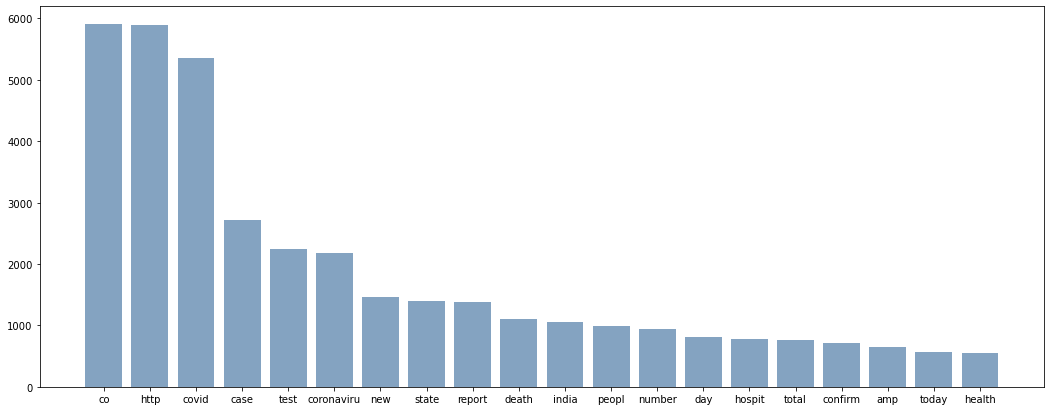

In [43]:
names = list(b.keys())
values = list(b.values())
plt.figure(figsize=(18,7))
plt.bar(range(len(b)), values, tick_label=names, color=(0.2, 0.4, 0.6, 0.6))
plt.show()

In [44]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)

In [45]:
#print(X)
#vectorizer2 = TfidfVectorizer()
#vectorizer2.fit(X_test)
#X_test = vectorizer2.transform(X_test)

In [46]:
#print(X_test)

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, stratify=Y, random_state=2)

In [48]:
DT_X = X
DT_Y = Y

After we have processed the data it is time to train some models. The models we tried are: logistic regression, multinomial naive bayes, k nearest neighbors, and random forests.
For each section we have included the execution time and a table which shows the F1 score and classification accuracy of the trained model.

## Logistic Regression ##

The first model we will be using is logistic regression. We chose it because we are solving a binary classification problem and it is a common and simple model for binary classification problems. It achieved a classification accuracy of 0.9648 on the training set and 0.9288 on the test set. The training time was 0.121s.
(For more detailed results see table below)

In [49]:
model = LogisticRegression()

In [50]:
start = time.time()
model.fit(X_train, Y_train)
end = time.time()
print("training time:", round(end-start, 3), "s")
start = time.time()
X_prediction = model.predict(X_train)
end = time.time()
print("predict time:", round(end-start, 3), "s")

training time: 0.186 s
predict time: 0.001 s


**Evaluation: Accuracy score**

In [51]:
#Accuracy score on training data

train_data_accuracy = accuracy_score(X_prediction, Y_train)

In [52]:
print('Accuracy training data: ', train_data_accuracy)

Accuracy training data:  0.9647614230315292


In [53]:
#Accuracy score on test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [54]:
print('Accuracy test data: ', test_data_accuracy)

Accuracy test data:  0.9287962234461055


In [55]:
print(confusion_matrix(Y_test,X_test_prediction))
print('\n')
print(classification_report(Y_test,X_test_prediction))

[[1231  102]
 [  79 1130]]


              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1333
           1       0.92      0.93      0.93      1209

    accuracy                           0.93      2542
   macro avg       0.93      0.93      0.93      2542
weighted avg       0.93      0.93      0.93      2542



## Multinomial Naive Bayes ##

The second model we will be using is multinomial naive bayes. It achieved a classification accuracy of 0.91 on the test set. The training time was 0.0025s.
(For more detailed results see table below)

In [56]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

**Fitting**

In [57]:
start = time.time()
nb.fit(X_train,Y_train)
end = time.time()
print("training time:", round(end-start, 8), "s")
start = time.time()
predictions = nb.predict(X_test)
end = time.time()
print("predict time:", round(end-start, 8), "s")

training time: 0.00400209 s
predict time: 0.00150013 s


**Predictions and Evaluations**

In [58]:
print(confusion_matrix(Y_test,predictions))
print('\n')
print(classification_report(Y_test,predictions))

[[1270   63]
 [ 163 1046]]


              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1333
           1       0.94      0.87      0.90      1209

    accuracy                           0.91      2542
   macro avg       0.91      0.91      0.91      2542
weighted avg       0.91      0.91      0.91      2542



## Including TF-IDF with pipeline ##

We decided to try adding TD-IDF to naive bayes using a pipeline. This lead to a decrease in classification accuracy to 0.90 and an increase in training time to 0.102 seconds.

In [62]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

In [64]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(text_processing_X, text_processing_Y,test_size=0.3,random_state=101)

In [66]:
start = time.time()
pipeline.fit(X_train,y_train)
end = time.time()
print("training time:", round(end-start, 8), "s")
start = time.time()
predictions = pipeline.predict(X_test)
end = time.time()
print("predict time:", round(end-start, 8), "s")

training time: 0.11327481 s
predict time: 0.03653073 s


In [67]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[1261   61]
 [ 191 1029]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1322
           1       0.94      0.84      0.89      1220

    accuracy                           0.90      2542
   macro avg       0.91      0.90      0.90      2542
weighted avg       0.90      0.90      0.90      2542



**Looks like Tf-Idf actually made things worse**

## Decision Tree ##
For our last ML method we decide to try a very simple model to compare to the others. The desicion tree took 0.454s to build and achieved a classification accuracy of 0.88.

In [68]:
from sklearn.tree import DecisionTreeClassifier

In [69]:
dtree = DecisionTreeClassifier()

In [70]:
X_train, X_test, y_train, y_test = train_test_split(DT_X, DT_Y, test_size=0.30, random_state=101)

In [71]:
start = time.time()
dtree.fit(X_train,y_train)
end = time.time()
print("training time:", round(end-start, 8), "s")
start = time.time()
predictions = dtree.predict(X_test)
end = time.time()
print("predict time:", round(end-start, 8), "s")

training time: 0.46139479 s
predict time: 0.00350308 s


**Predictions**

In [72]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1322
           1       0.88      0.86      0.87      1220

    accuracy                           0.88      2542
   macro avg       0.88      0.88      0.88      2542
weighted avg       0.88      0.88      0.88      2542



In [73]:
print(confusion_matrix(y_test,predictions))

[[1177  145]
 [ 169 1051]]


## Random forest ##
We also wanted to try solving the problem using random forests. These are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks like this one, the output of the random forest is the class selected by most trees.
The forest took a long time to build with a training time of 37.33s but nevertheless, it achieved the highest classification accuracy of 0.93.

In [74]:
from sklearn.ensemble import RandomForestClassifier

In [75]:
rfc = RandomForestClassifier(n_estimators=600)

In [76]:
start = time.time()
rfc.fit(X_train,y_train)
end = time.time()
print("training time:", round(end-start, 8), "s")
start = time.time()
predictions = rfc.predict(X_test)
end = time.time()
print("predict time:", round(end-start, 8), "s")

training time: 37.40861082 s
predict time: 0.42586493 s


**Predictions**

In [77]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1322
           1       0.93      0.93      0.93      1220

    accuracy                           0.93      2542
   macro avg       0.93      0.93      0.93      2542
weighted avg       0.93      0.93      0.93      2542



In [78]:
print(confusion_matrix(y_test,predictions))

[[1236   86]
 [  90 1130]]


## KNN ##
Lastly, we tried using the k-nearest neighbors method to solve our classification problem. This yielded a classification accuracy of 0.90 with a really fast training time of 0.001s but a relatively slow prediction time of 0.39s. We tried various values of K to optimize the result(see image below).

In [79]:
from sklearn.neighbors import KNeighborsClassifier

In [80]:
knn = KNeighborsClassifier(n_neighbors=3)

In [81]:
start = time.time()
knn.fit(X_train,y_train)
end = time.time()
print("training time:", round(end-start, 8), "s")
start = time.time()
pred = knn.predict(X_test)
end = time.time()
print("predict time:", round(end-start, 8), "s")

training time: 0.0010004 s
predict time: 0.33728886 s


In [82]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1322
           1       0.88      0.91      0.90      1220

    accuracy                           0.90      2542
   macro avg       0.90      0.90      0.90      2542
weighted avg       0.90      0.90      0.90      2542



**Choosing K value**

In [183]:
error_rate = []

# Will take some time
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

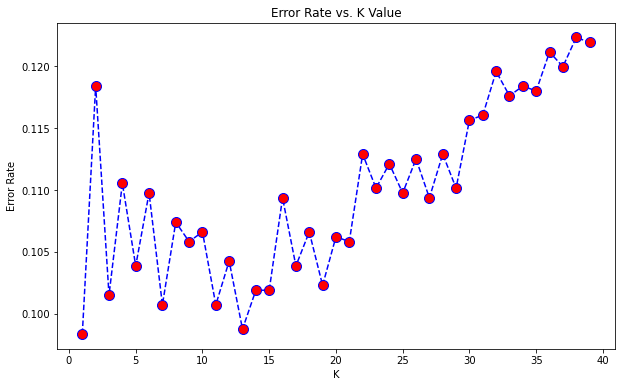

In [184]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [185]:
knn = KNeighborsClassifier(n_neighbors=14)

In [83]:
start = time.time()
knn.fit(X_train,y_train)
end = time.time()
print("training time:", round(end-start, 8), "s")
start = time.time()
pred = knn.predict(X_test)
end = time.time()
print("predict time:", round(end-start, 8), "s")

training time: 0.0011611 s
predict time: 0.3111074 s


In [84]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1322
           1       0.88      0.91      0.90      1220

    accuracy                           0.90      2542
   macro avg       0.90      0.90      0.90      2542
weighted avg       0.90      0.90      0.90      2542



In [85]:
print(confusion_matrix(y_test,pred))

[[1178  144]
 [ 114 1106]]


## Evaluation ##
In the end, the random forest model was the most successful with a classification accuracy of 0.93. The tables below show our chosen models' performances in terms of time and in therms of accuracy.
To summarize all the accuracies:

| Model                 | Class. Accuracy | F1 Score |
|-----------------------|-----------------|----------|
| Logistic Regression   | 0.929           | 0.93     |
| Multinom. Naive Bayes | 0.91            | 0.91     |
| MNB with pipeline     | 0.90            | 0.90     |
| Decision Tree         | 0.88            | 0.88     |
| Random Forest         | 0.93            | 0.93     |
| KNN                   | 0.90            | 0.90     |

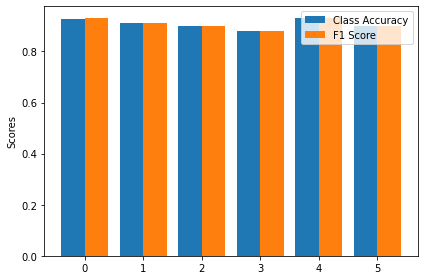

In [110]:
classAcc = [0.929,0.91,0.90,0.88,0.93,0.90,]
names = ['Logistic Regression','Multinomial NB','Bow+TfIdf+MNB','Decision Tree','RF(n=600)','KNN(k=14)']
f1Scores = [0.93,0.91, 0.90, 0.88, 0.93, 0.90]

#plt.figure(figsize=(18,7))
x = np.arange(len(names))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.2, classAcc, width, label='Class Accuracy')
rects2 = ax.bar(x + 0.2, f1Scores, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.legend()

fig.tight_layout()
plt.show()

In [86]:
Times = [['Logistic Regression', 0.119, 0.001 ],['Multinomial NB',0.0025, 0.00105 ],['Decision Tree', 0.45238, 0.002891],['Bow+TfIdf+MNB',0.10258, 0.03653], ['RF(n=600)', 37.5807 , 0.42586], ['KNN(k=14)', 0.0010, 0.3933]]

In [87]:
dfTimes = pd.DataFrame(Times, columns = ['Model', 'Training time (s)', 'Prediction time (s)'])

In [88]:
dfTimes

,Model,Training time (s),Prediction time (s)
0,Logistic Regression,0.11900,0.001000
1,Multinomial NB,0.00250,0.001050
2,Decision Tree,0.45238,0.002891
3,Bow+TfIdf+MNB,0.10258,0.036530
4,RF(n=600),37.58070,0.425860
5,KNN(k=14),0.00100,0.393300
